# Supplemental Figure 1B: MNIST autoencoder reconstructions

In [1]:
%matplotlib widget

import os, glob, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from functools import lru_cache
from pathlib import Path

from PIL import Image
from tifffile import imread as tiff_imread

print("Matplotlib:", plt.matplotlib.__version__)


Matplotlib: 3.10.5


In [2]:
# ─────────────────────────────────────────────────────────────
# CONFIG — point to your MNIST AE results
# ─────────────────────────────────────────────────────────────
RESULTS_DIR = Path("..") / "data" / "mnist-ae"     # change if needed
SPLIT       = "recon_train"         # "recon_train" or "recon_val"

ORIG_DIR  = os.path.join(RESULTS_DIR, "recon_train" if SPLIT=="recon_train" else "recon_val", "originals")
RECON_DIR = os.path.join(RESULTS_DIR, "recon_train" if SPLIT=="recon_train" else "recon_val", "reconstructions")

print("ORIG_DIR :", ORIG_DIR)
print("RECON_DIR:", RECON_DIR)
assert os.path.isdir(ORIG_DIR),  f"Not a directory: {ORIG_DIR}"
assert os.path.isdir(RECON_DIR), f"Not a directory: {RECON_DIR}"


ORIG_DIR : ..\data\mnist-ae\recon_train\originals
RECON_DIR: ..\data\mnist-ae\recon_train\reconstructions


In [3]:
pat = re.compile(r"^(orig|recon)_epoch(\d+)_(\d+)\.(?:png|tif|tiff)$", re.IGNORECASE)

def parse_epoch_index(directory, prefix):
    data = {}
    for ext in ("png", "tif", "tiff"):
        for p in glob.glob(os.path.join(directory, f"{prefix}_epoch*_*." + ext)):
            m = pat.match(os.path.basename(p))
            if not m:
                continue
            _, ep_str, idx_str = m.groups()
            ep, idx = int(ep_str), int(idx_str)
            data.setdefault(ep, {})[idx] = p
    return data

orig = parse_epoch_index(ORIG_DIR, "orig")
reco = parse_epoch_index(RECON_DIR, "recon")
if not orig or not reco:
    raise RuntimeError("No matching files found. Check ORIG_DIR/RECON_DIR and filename pattern.")

epochs = sorted(set(orig).intersection(reco))
indices_by_epoch = {e: sorted(set(orig[e]).intersection(reco[e])) for e in epochs}
epochs = [e for e in epochs if indices_by_epoch[e]]
if not epochs:
    raise RuntimeError("No overlapping (epoch, index) pairs between originals and reconstructions.")

current_epoch = epochs[0]
current_index = indices_by_epoch[current_epoch][0]

print(f"Found epochs: {len(epochs)}. First epoch {current_epoch} has {len(indices_by_epoch[current_epoch])} indices.")


Found epochs: 100. First epoch 1 has 100 indices.


In [4]:
@lru_cache(maxsize=1024)
def read_img(path):
    ext = Path(path).suffix.lower()
    if ext in {".tif", ".tiff"}:
        img = tiff_imread(path)
    else:
        img = np.array(Image.open(path))
    if img.ndim == 3 and img.shape[-1] == 1:
        img = img[..., 0]
    elif img.ndim == 3 and img.shape[-1] >= 3:
        img = img[..., 0]
    return img

def vmin_vmax(arr):
    if np.issubdtype(arr.dtype, np.integer):
        info = np.iinfo(arr.dtype)
        return float(info.min), float(info.max)
    return float(np.nanmin(arr)), float(np.nanmax(arr)) if np.isfinite(arr).all() else (0.0, 1.0)


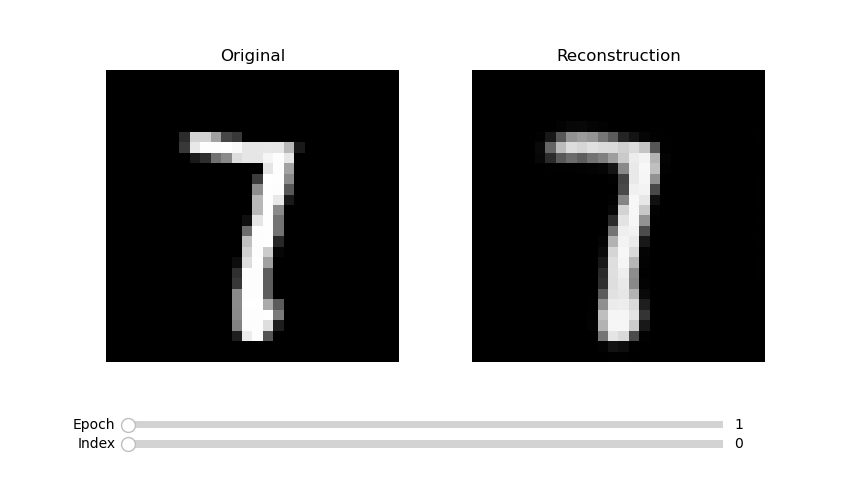

In [5]:
#| label: sfig1b_data

fig, (ax_o, ax_r) = plt.subplots(1, 2, figsize=(8.5, 4.8))
plt.subplots_adjust(bottom=0.22, wspace=0.25)

img_o = read_img(orig[current_epoch][current_index])
img_r = read_img(reco[current_epoch][current_index])
v0, V0 = vmin_vmax(img_o)
v1, V1 = vmin_vmax(img_r)

im_o = ax_o.imshow(img_o, cmap="gray", vmin=v0, vmax=V0)
ax_o.set_title("Original")
ax_o.axis("off")

im_r = ax_r.imshow(img_r, cmap="gray", vmin=v1, vmax=V1)
ax_r.set_title("Reconstruction")
ax_r.axis("off")

# Sliders
ax_epoch = plt.axes([0.15, 0.10, 0.70, 0.03])
ax_index = plt.axes([0.15, 0.06, 0.70, 0.03])

epoch_slider = Slider(ax_epoch, "Epoch",
                      valmin=min(epochs), valmax=max(epochs),
                      valinit=current_epoch, valstep=1, valfmt="%0.0f")

idxs = indices_by_epoch[current_epoch]
index_slider = Slider(ax_index, "Index",
                      valmin=idxs[0], valmax=idxs[-1],
                      valinit=current_index, valstep=1, valfmt="%0.0f")

def update_images(ep, idx):
    o = read_img(orig[ep][idx])
    r = read_img(reco[ep][idx])
    im_o.set_data(o); im_o.set_clim(*vmin_vmax(o))
    im_r.set_data(r); im_r.set_clim(*vmin_vmax(r))
    # Titles remain simple (no epoch/index)
    fig.canvas.draw_idle()

def on_epoch_change(val):
    ep = int(val)
    idxs = indices_by_epoch.get(ep, [])
    if not idxs:
        return
    cur = int(index_slider.val)
    cur = min(max(cur, idxs[0]), idxs[-1])
    index_slider.eventson = False
    index_slider.valmin, index_slider.valmax = idxs[0], idxs[-1]
    index_slider.ax.set_xlim(idxs[0], idxs[-1])
    index_slider.set_val(cur)
    index_slider.eventson = True
    update_images(ep, cur)

def on_index_change(val):
    idx = int(val)
    ep = int(epoch_slider.val)
    if idx in orig.get(ep, {}) and idx in reco.get(ep, {}):
        update_images(ep, idx)

epoch_slider.on_changed(on_epoch_change)
index_slider.on_changed(on_index_change)

fig.canvas.toolbar_visible = True
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
plt.show()
